In [1]:
''' import '''
import scipy.io as io
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
''' load data '''
data = io.loadmat('./data/hw3_prob2.mat')

f_orig = data['f']
x_orig = data['x_orig']

M, N = f_orig.shape

In [3]:
''' hyper param '''
MU = 0.02
LAMBDA = 0.0002
MAXITERS = 1000
CRIT = 1e-4

In [4]:
''' function '''
def soft_thres(z, t):
    return np.sign(z)*np.maximum(np.abs(z) - t, 0)

# ADMM (2d)

In [5]:
''' TV (D_h, D_v) '''
# no-pading
# def D_h(x):
#     return x[1:,:] - x[:-1,:]
# def D_h_T(x):
#     return x[:-1,:] - x[1:,:]

# def D_v(x):
#     return x[:,1:] - x[:,:-1]
# def D_v_T(x):
#     return x[:,:-1] - x[:,1:]

# padding
def D_h(x):
    return np.roll(x, -1, axis=0) - x   # i+1 - i
def D_h_T(x):
    return np.roll(x, 1, axis=0) - x    # i-1 - i => (i - i+1로 계산하면 성능저하)

def D_v(x):
    return np.roll(x, -1, axis=1) - x
def D_v_T(x):
    return np.roll(x, 1, axis=1) - x

In [6]:
''' ADMM (2d) '''

fn_admm = []
xn_admm = []

f = f_orig
x = np.zeros((M,N))
x_prev = x

d_h = np.zeros((M,N))
q_h = np.zeros((M,N))
d_v = np.zeros((M,N))
q_v = np.zeros((M,N))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(x - f)**2 + la.norm(d_h, 1) + la.norm(d_v, 1) \
        + (LAMBDA/2)*la.norm(d_h - D_h(x) - q_h)**2 + (LAMBDA/2)*la.norm(d_v - D_v(x) - q_v)**2

    # update
    x = f + (LAMBDA/MU)*(D_h_T(d_h - D_h(x) - q_h) + D_v_T(d_v - D_v(x) - q_v))
    # x = MU*f/(MU + 4*LAMBDA) + LAMBDA/(MU + 4*LAMBDA)*(D_vh(x) + D_h.T@(d_h - q_h) + D_v.T@(d_v - q_v))

    d_h = soft_thres(D_h(x) + q_h, 1/LAMBDA)
    d_v = soft_thres(D_v(x) + q_v, 1/LAMBDA)
    q_h = q_h + (D_h(x) - d_h)
    q_v = q_v + (D_v(x) - d_v)

    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (la.norm(x - x_prev)/la.norm(x) < CRIT):
        break
    
    x_prev = x

    # history
    fn_admm.append(fn)
    xn_admm.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, f = {fn:.8f}')

# optimal
x_admm = x

i = 0   , |x-x|/|x| = 1.00000000, f = 41338790.55061270
i = 1   , |x-x|/|x| = 0.02705183, f = 795476.25768850
i = 2   , |x-x|/|x| = 0.01082255, f = 1647487.85636805
i = 3   , |x-x|/|x| = 0.01117327, f = 2811054.60519039
i = 4   , |x-x|/|x| = 0.01064818, f = 4230905.16487931
i = 5   , |x-x|/|x| = 0.01004826, f = 5846537.52582167
i = 6   , |x-x|/|x| = 0.00852872, f = 6911968.45288913
i = 7   , |x-x|/|x| = 0.00797991, f = 7461903.04250290
i = 8   , |x-x|/|x| = 0.00651635, f = 7947831.33177785
i = 9   , |x-x|/|x| = 0.00584516, f = 8540391.59263838
i = 10  , |x-x|/|x| = 0.00529220, f = 9232841.66283748
i = 11  , |x-x|/|x| = 0.00500430, f = 9962073.98695081
i = 12  , |x-x|/|x| = 0.00477059, f = 10710758.15264380
i = 13  , |x-x|/|x| = 0.00455438, f = 11472954.77155844
i = 14  , |x-x|/|x| = 0.00435005, f = 12245018.41911869
i = 15  , |x-x|/|x| = 0.00415903, f = 13023545.94096408
i = 16  , |x-x|/|x| = 0.00397431, f = 13806654.54264429
i = 17  , |x-x|/|x| = 0.00380070, f = 14591547.11015876
i = 

In [7]:
''' ADMM + reweighted L1 (2d) '''

DELTA = 0.39

fn_admm_rew = []
xn_admm_rew = []

f = f_orig
x = x_admm
# x = np.zeros((M,N))
x_prev = x

d_h = np.zeros((M,N))
q_h = np.zeros((M,N))
d_v = np.zeros((M,N))
q_v = np.zeros((M,N))

W_h = np.ones((M,N))
W_v = np.ones((M,N))

for k in range(MAXITERS):

    # f
    fn = (MU/2)*la.norm(x - f)**2 + la.norm(d_h, 1) + la.norm(d_v, 1) \
        + (LAMBDA/2)*la.norm(d_h - W_h*D_h(x) - q_h)**2 + (LAMBDA/2)*la.norm(d_v - W_v*D_v(x) - q_v)**2

    # update
    x = f + (LAMBDA/MU)*(D_h_T(W_h*(d_h - W_h*D_h(x) - q_h)) + D_v_T(W_v*(d_v - W_v*D_v(x) - q_v)))
    # x = MU*f/(MU + 4*LAMBDA) + LAMBDA/(MU + 4*LAMBDA)*(D_vh(x) + D_h.T@(d_h - q_h) + D_v.T@(d_v - q_v))

    d_h = soft_thres(W_h*D_h(x) + q_h, 1/LAMBDA)
    d_v = soft_thres(W_v*D_v(x) + q_v, 1/LAMBDA)
    q_h = q_h + (W_h*D_h(x) - d_h)
    q_v = q_v + (W_v*D_v(x) - d_v)

    W_h = 1 / (np.abs(d_h) + DELTA)
    W_v = 1 / (np.abs(d_v) + DELTA)

    # stop condition
    xcon = la.norm(x - x_prev)/la.norm(x)
    if (k >= 1) and (xcon < CRIT):
        break
    
    x_prev = x

    # history
    fn_admm_rew.append(fn)
    xn_admm_rew.append(xcon)
    print(f'i = {k:<4d}, |x-x|/|x| = {xcon:.8f}, f = {fn:.8f}')

# optimal
x_admm_rew = x

i = 0   , |x-x|/|x| = 0.19256955, f = 1655279.30854869
i = 1   , |x-x|/|x| = 0.11713018, f = 2434292.31078170
i = 2   , |x-x|/|x| = 0.03101179, f = 4666813.44877285
i = 3   , |x-x|/|x| = 0.06294842, f = 7812963.19304018
i = 4   , |x-x|/|x| = 0.14365653, f = 7944655.80591377
i = 5   , |x-x|/|x| = 0.10677954, f = 8628058.56777535
i = 6   , |x-x|/|x| = 0.06046706, f = 8497621.28125328
i = 7   , |x-x|/|x| = 0.04388214, f = 9459219.55989844
i = 8   , |x-x|/|x| = 0.03465400, f = 9605802.04394149
i = 9   , |x-x|/|x| = 0.02900733, f = 10416604.25963311
i = 10  , |x-x|/|x| = 0.02473778, f = 10564544.72472313
i = 11  , |x-x|/|x| = 0.02192418, f = 11246458.57846411
i = 12  , |x-x|/|x| = 0.01965833, f = 11379129.05381137
i = 13  , |x-x|/|x| = 0.01783050, f = 11965792.21163179
i = 14  , |x-x|/|x| = 0.01743638, f = 12083976.17528012
i = 15  , |x-x|/|x| = 0.01754197, f = 12596360.11632013
i = 16  , |x-x|/|x| = 0.01552541, f = 12701928.36872373
i = 17  , |x-x|/|x| = 0.01556037, f = 13162630.42791392
i

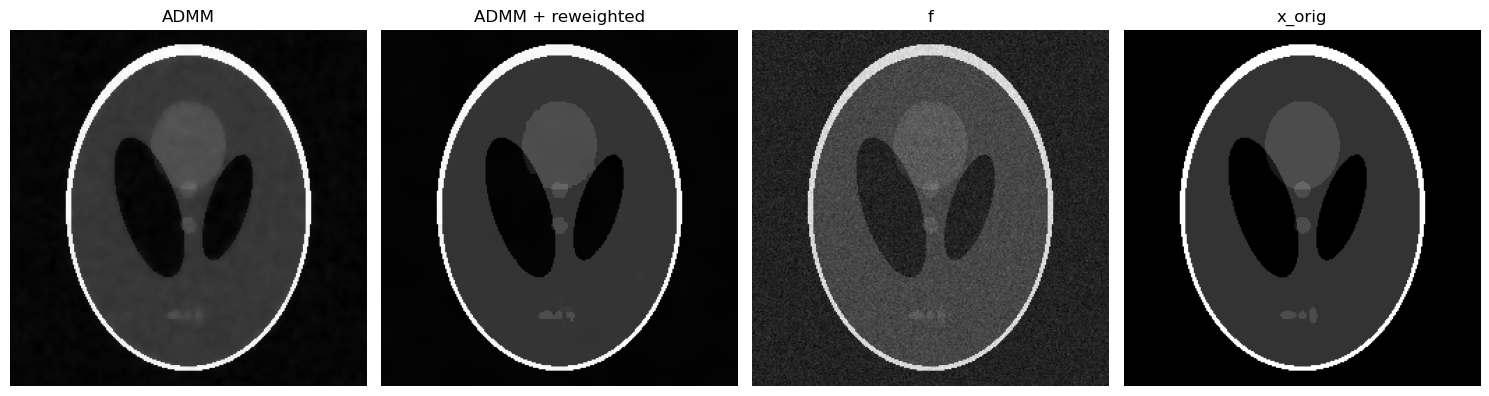

In [8]:
''' plot '''
_, axs = plt.subplots(1,4, figsize=(15,5))
axs[0].imshow(x_admm, cmap='gray')
axs[0].set_title('ADMM')
axs[0].axis('off')

axs[1].imshow(x_admm_rew, cmap='gray')
axs[1].set_title('ADMM + reweighted')
axs[1].axis('off')

axs[2].imshow(f_orig, cmap='gray')
axs[2].set_title('f')
axs[2].axis('off')

axs[3].imshow(x_orig, cmap='gray')
axs[3].set_title('x_orig')
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [17]:
''' find delta : reweighted L1 (ADMM)  '''

MAXITERS = 300

fn_hist = []
xn_hist = []
x_hist = []

f = f_orig
# delta_list = np.linspace(0.2, 5, 12)
delta_list = np.linspace(0.2, 10, 12)

for delta in delta_list:

    x = np.zeros((M,N))
    x_prev = x

    d_h = np.zeros((M,N))
    q_h = np.zeros((M,N))
    d_v = np.zeros((M,N))
    q_v = np.zeros((M,N))

    W_h = np.ones((M,N))
    W_v = np.ones((M,N))

    for k in range(MAXITERS):

        # f
        fn = (MU/2)*la.norm(x - f)**2 + la.norm(d_h, 1) + la.norm(d_v, 1) \
            + (LAMBDA/2)*la.norm(d_h - W_h*D_h(x) - q_h)**2 + (LAMBDA/2)*la.norm(d_v - W_v*D_v(x) - q_v)**2

        # update
        x = f + (LAMBDA/MU)*(D_h_T(W_h*(d_h - W_h*D_h(x) - q_h)) + D_v_T(W_v*(d_v - W_v*D_v(x) - q_v)))
        # x = MU*f/(MU + 4*LAMBDA) + LAMBDA/(MU + 4*LAMBDA)*(D_vh(x) + D_h.T@(d_h - q_h) + D_v.T@(d_v - q_v))

        d_h = soft_thres(W_h*D_h(x) + q_h, 1/LAMBDA)
        d_v = soft_thres(W_v*D_v(x) + q_v, 1/LAMBDA)
        q_h = q_h + (W_h*D_h(x) - d_h)
        q_v = q_v + (W_v*D_v(x) - d_v)

        W_h = 1 / (np.abs(d_h) + delta)
        W_v = 1 / (np.abs(d_v) + delta)

        # stop condition
        xcon = la.norm(x - x_prev)/la.norm(x)
        if (k >= 1) and (xcon < CRIT):
            break
        
        x_prev = x

    # history
    fn_hist.append(fn)
    xn_hist.append(xcon)
    x_hist.append(x)
    print(f'delta = {delta:.2f}, i = {k:<4d}, |x-x|/|x| = {xcon:.6f}, f = {fn:.2f}')


delta = 0.20, i = 299 , |x-x|/|x| = 2.017365, f = 711884591.59
delta = 0.64, i = 299 , |x-x|/|x| = 0.002916, f = 37556124.77
delta = 1.07, i = 299 , |x-x|/|x| = 0.005319, f = 80935933.28
delta = 1.51, i = 299 , |x-x|/|x| = 0.004843, f = 120138299.56
delta = 1.95, i = 299 , |x-x|/|x| = 0.004252, f = 139116846.29
delta = 2.38, i = 299 , |x-x|/|x| = 0.003944, f = 145617577.20
delta = 2.82, i = 299 , |x-x|/|x| = 0.003079, f = 145499926.30
delta = 3.25, i = 299 , |x-x|/|x| = 0.002667, f = 141954391.79
delta = 3.69, i = 299 , |x-x|/|x| = 0.002531, f = 136609409.20
delta = 4.13, i = 299 , |x-x|/|x| = 0.002061, f = 130365337.39
delta = 4.56, i = 299 , |x-x|/|x| = 0.001802, f = 123672509.18
delta = 5.00, i = 299 , |x-x|/|x| = 0.001573, f = 116840742.84


In [14]:
# argmin
fn_min_idx = np.argmin(fn_hist[:30])
xn_min_idx = np.argmin(xn_hist[:30])

print(f'fn_min : {delta_list[fn_min_idx]:.3f}')
print(f'xn_min : {delta_list[xn_min_idx]:.3f}')

fn_min : 0.480
xn_min : 0.480


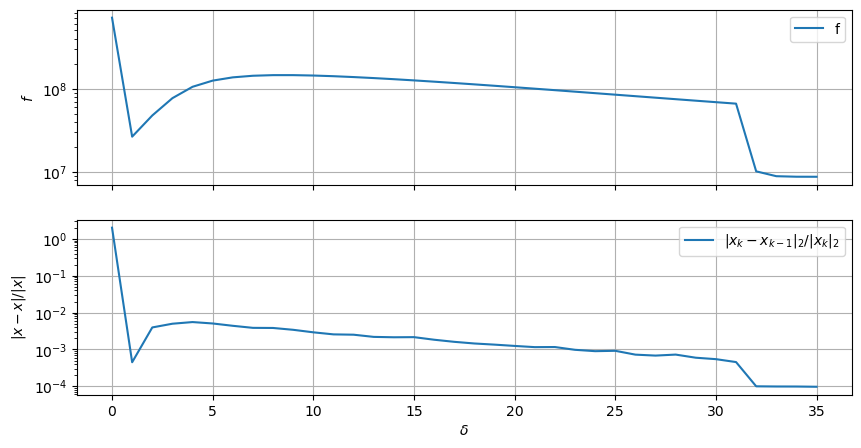

In [15]:
# plot graph
_, axs = plt.subplots(2,1, sharex=True, figsize=(10,5))
axs[0].semilogy(fn_hist, label='f')
# axs[0].vlines(fn_min_idx, min(fn_hist), max(fn_hist), colors='red', linestyles='--', label='$\\delta=0.4$')
axs[0].set_ylabel('$f$')
axs[0].legend()
axs[0].grid()

axs[1].semilogy(xn_hist, label='$|x_k - x_{k-1}|_2/|x_k|_2$')
# axs[1].vlines(xn_min_idx, 0, max(xn_hist), colors='red', linestyles='--', label='$\\delta=0.5$')
axs[1].set_ylabel('$|x-x|/|x|$')
axs[1].set_xlabel('$\\delta$')
axs[1].legend()
axs[1].grid()

plt.show()

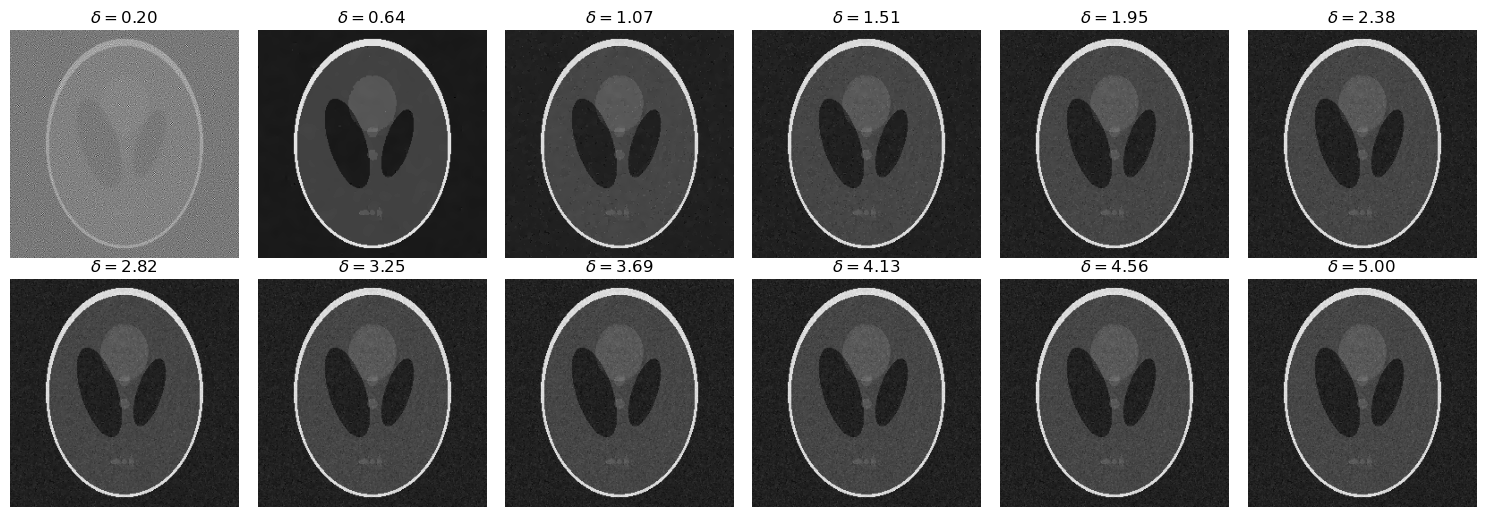

In [18]:
# plot images
num_img = len(x_hist)
cols = 6
rows = (num_img + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 2.6 * rows))

for i, ax in enumerate(axs.flat):
    if i < num_img:
        ax.imshow(x_hist[i], cmap='gray')
        ax.set_title(f'$\\delta={delta_list[i]:.2f}$')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()